<a href="https://colab.research.google.com/github/BrianArnesto/masterThesis/blob/main/Master_Thesis_Fake_News_Detection_of_Indonesian_Langguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html
https://scikit-learn.org/stable/modules/sgd.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
https://github.com/leelaylay/TweetSemEval
https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44
https://github.com/cbaziotis/datastories-semeval2017-task4


#Install the required library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.4 MB/s eta 0:00:00


In [ ]:
!pip install pycaret 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 17

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 6.4 MB/s eta 0:00:00


# Load the *library*

In [ ]:
import requests
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import pycaret
from transformers import BertTokenizer, AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from google.colab import drive
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from transformers import AutoTokenizer, AutoModel
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset

import transformers as trf
import tensorflow as tf
from transformers import TFBertModel, TFBertTokenizer




import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch.nn as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


drive.mount('/content/drive')
# specify GPU
device = torch.device("cuda")


Mounted at /content/drive


#Data Fetch 

In [ ]:
url = 'http://maps.googleapis.com/maps/api/directions/json'

params = dict(
    origin='Chicago,IL',
    destination='Los+Angeles,CA',
    waypoints='Joplin,MO|Oklahoma+City,OK',
    sensor='false'
)

resp = requests.get(url=url, params=params)
data = resp.json() # Check the JSON Response Content documentation below

print(data)

In [ ]:
url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2',
    'limit': 1000
}

resp = requests.post(url=url, headers=headers, data=body)
data = resp.json()

print(data)

In [ ]:
len(data)

In [ ]:
#Get total number of dataset in mafindo server
url = 'https://yudistira.turnbackhoax.id/api/antihoax/get_total'
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2'
}

resp = requests.post(url=url, headers=headers, data=body)
total = resp.json() # Check the JSON Response Content documentation below

print(total)

In [ ]:
def fetch_data(offset):
  url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

  headers = {
      'Content-Type': 'application/x-www-form-urlencoded',
      'Accept': 'application/json'
  }

  body = {
      'key': '231b200cxb534x5c797a432dd30b0vc2',
      'limit': 1000,
      'offset': offset
  }

  resp = requests.post(url=url, headers=headers, data=body)
  data = resp.json()
  return data

data_list = []
offset = 0
for i in range(10):
  d = fetch_data(offset)
  offset += len(d)
  data_list += d
  # sleep(2)

print(len(data_list))

KeyboardInterrupt: ignored

In [ ]:
data_list

In [ ]:
d = fetch_data(10000)
data_list += d

In [ ]:
data_list

In [ ]:
#Convert json dataset into pandas dataframe
df = pd.DataFrame.from_records(data_list)

In [ ]:
#export the dataset into csv in the google drive
df.to_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

#Load the dataset

In [ ]:
#load the main dataset
df = pd.read_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

#load the preproccess dataaset
#df = pd.read_csv('/content/drive/MyDrive/thesis/data_preprocesedIndonesian.csv', sep='\t')

#Load the Indonesian Langguage stopword
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/thesis/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

#Load Indonesian slang dataset
alay_dict = pd.read_csv('/content/drive/MyDrive/thesis/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

#Data Preprocessing

###Overview of the dataset

In [ ]:
df.head()

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,"\nLiputan6.com, Jakarta - Kabar tentang artis ...",\nCek Fakta Liputan6.com menelusuri kabar tent...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,"\nLiputan6.com, Jakarta - Klaim tentang menemp...",\nCek Fakta Liputan6.com menelusuri klaim mene...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,Akun Facebook bernama TH K menyebarluaskan tau...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,"\nLiputan6.com, Jakarta - Sebuah video yang di...",\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."


In [ ]:
print("Shape: ", df.shape)
df.head(15)

Shape:  (10756, 16)


,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,"\nLiputan6.com, Jakarta - Kabar tentang artis ...",\nCek Fakta Liputan6.com menelusuri kabar tent...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,"\nLiputan6.com, Jakarta - Klaim tentang menemp...",\nCek Fakta Liputan6.com menelusuri klaim mene...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,Akun Facebook bernama TH K menyebarluaskan tau...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,"\nLiputan6.com, Jakarta - Sebuah video yang di...",\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
5,5,10923,36,2,Misleading Content,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,Akun Twitter dengan nama pengguna “uytimes” me...,"Berdasarkan hasil penelusuran, narasi tersebut...",https://www.douyin.com/video/70471093072544924...,twitter.com,https://archive.cob.web.id/archive/1667926200....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: mixed, s...",Hasil Periksa Fakta Khairunnisa A.\r\n\r\nHoak...
6,6,10922,36,2,Misleading Content,[SALAH] Wanita berusia 399 Tahun,"""399 Years Women, Oldest woman in the world""\n...",Beredar video Tiktok yang diunggah oleh @bria...,https://turnbackhoax.id/2022/04/05/salah-video...,Tiktok,https://archive.cob.web.id/archive/1667920179....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-09,"Cek fakta, tbh, tema: unik, alat: mixed, SC: T...",Hasil Periksa Fakta Dyah Febriyani. Narasi dal...
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vaks...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
8,8,10920,29,2,-,Cek Fakta: Tidak Benar Mantan Presiden Soehart...,"\nLiputan6.com, Jakarta - Beredar di media sos...",\nCek Fakta Liputan6.com menelusuri dan menemu...,https://www.liputan6.com/news/read/5115252/jok...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512069...,https://cdn1-production-images-kly.akamaized.n...,NaN,2022-11

In [ ]:
df.describe()

,Unnamed: 0,id,status
count,10756.000000,10756.000000,10756.000000
mean,5377.500000,5488.900149,2.128486
std,3105.134082,3152.556646,0.841311
min,0.000000,4.000000,0.000000
25%,2688.750000,2743.750000,2.000000
50%,5377.500000,5509.500000,2.000000
75%,8066.250000,8223.250000,2.000000
max,10755.000000,10928.000000,15.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10756 entries, 0 to 10755
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      10756 non-null  int64 
 1   id              10756 non-null  int64 
 2   authors         10337 non-null  object
 3   status          10756 non-null  int64 
 4   classification  10756 non-null  object
 5   title           10755 non-null  object
 6   content         10466 non-null  object
 7   fact            10553 non-null  object
 8   references      10694 non-null  object
 9   source_issue    10031 non-null  object
 10  source_link     7642 non-null   object
 11  picture1        10464 non-null  object
 12  picture2        1981 non-null   object
 13  tanggal         10756 non-null  object
 14  tags            10731 non-null  object
 15  conclusion      6571 non-null   object
dtypes: int64(3), object(13)
memory usage: 1.3+ MB


In [ ]:
df['classification'].isnull().sum()

0

In [ ]:
df['classification'].describe()

count                  10756
unique                    10
top       Misleading Content
freq                    2629
Name: classification, dtype: object

In [ ]:
df['classification'].unique()

array(['-', 'Misleading Content', 'Fabricated Content',
       'Impostor Content', 'Manipulated Content', 'False Context',
       'Satire', 'False Connection', 'Clarification', 'TRUE'],
      dtype=object)

###Total count of each category

In [ ]:
print(Counter(df['classification'].values))

Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})


In [ ]:
df.loc[df['classification'] == '-'] 
#to do 
#check the content

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,"\nLiputan6.com, Jakarta - Kabar tentang artis ...",\nCek Fakta Liputan6.com menelusuri kabar tent...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,"\nLiputan6.com, Jakarta - Klaim tentang menemp...",\nCek Fakta Liputan6.com menelusuri klaim mene...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,"\nLiputan6.com, Jakarta - Sebuah video yang di...",\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vaks...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,10747,13,NaN,1,-,(EDUKASI) 7 Tipe Informasi Hoax,NaN,"Dari yang saya amati, “tema” pesan hoax biasan...",https://www.facebook.com/youthmanualid/posts/6...,NaN,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Tipe HOAX, cekfakta",NaN
10748,10748,12,NaN,2,-,[KLARIFIKASI] Foto Wagub DKI Sedang Berada di ...,https://turnbackhoax.id/wp-content/uploads/201...,1. Secara resmi dan sah Djarot beragama Islam\...,http://www.satuharapan.com/…/wagub-dki-sumbang...,facebook.com,NaN,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Djarot, Kristen, cekfakta",NaN
10749,10749,11,NaN,2,-,[HOAX] Uang Bayaran dari Tim Basuki-Djarot,https://turnbackhoax.id/wp-content/uploads/201...,Foto berupa tiga lembar uang Rp. 100.000 denga...,https://www.facebook.com/groups/fafhh/permalin...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Badja Uang, cekfakta",NaN
10750,10750,10,NaN,2,-,[DISINFORMASI] Perubahan Suara saat Hitungan K...,Perubahan suara pd saat hitungan KPU sdh 100%....,"“Iya, ada kesalahan input data, di TPS 10 Kelu...",https://www.facebook.com/groups/fafhh/permalin...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Disinformasi, Anies - Sandi, KPU, cekfakta",NaN


###Preprocess the text data

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
stemming:  ekonomi indonesia sedang dalam tumbuh yang bangga
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe


In [ ]:
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    return text

In [ ]:
df=df.astype(str)

In [ ]:
df['content'] = df['content'].apply(preprocess)

In [ ]:
df['fact'] = df['fact'].apply(preprocess)

In [ ]:
print("Shape: ", df.shape)
df.head(15)

Shape:  (10756, 16)


,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,cek fakta liputan6 com telusur kabar a is niki...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,cek fakta liputan6 com telusur klaim tempel ad...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,cek fakta liputan6 com telusur video klaim ora...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,cek fakta liputan6 com telusur klaim video kon...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
5,5,10923,36,2,Misleading Content,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,https://www.douyin.com/video/70471093072544924...,twitter.com,https://archive.cob.web.id/archive/1667926200....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: mixed, s...",Hasil Periksa Fakta Khairunnisa A.\r\n\r\nHoak...
6,6,10922,36,2,Misleading Content,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,https://turnbackhoax.id/2022/04/05/salah-video...,Tiktok,https://archive.cob.web.id/archive/1667920179....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-09,"Cek fakta, tbh, tema: unik, alat: mixed, SC: T...",Hasil Periksa Fakta Dyah Febriyani. Narasi dal...
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,liputan6 com jaka a cek fakta liputan6 com kla...,cek fakta liputan6 com telusur klaim vaksin ge...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
8,8,10920,29,2,-,Cek Fakta: Tidak Benar Mantan Presiden Soehart...,liputan6 com jaka a edar media sosial postinga...,cek fakta liputan6 com telusur temu a ikel jud...,https://www.liputan6.com/news/read/5115252/jok...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512069...,https://cdn1-production-images-kly.akamaized.n...,nan,2022-11-09,"cekfakta, li

##Remove all '-' classification 

The '-' classification will be used to evaluate the model 



In [ ]:
df

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,cek fakta liputan6 com telusur kabar a is niki...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,cek fakta liputan6 com telusur klaim tempel ad...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,cek fakta liputan6 com telusur video klaim ora...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,cek fakta liputan6 com telusur klaim video kon...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10751,10751,9,nan,2,-,[DISINFORMASI] Perlakuan Berbeda antara GNPF M...,gera nasional fatwa dana sedekah umat sumber p...,1 teman ahok periksa komisi berantas korupsi l...,https://news.detik.com/berita/3312414/begini-a...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,nan,2018-04-29,"Disinformasi, GNPF MUI, TEMAN AHOK, cekfakta",nan
10752,10752,8,nan,1,TRUE,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,garuda indonesia langsung klarifikasi kait per...,(1) http://megapolitan.kompas.com/read/2017/11...,twitter.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,2017-11-21,"garudaindonesia, pilot, cina, sara, cekfakta",nan
10753,10753,7,nan,2,Fabricated Content,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,direktur jenderal selenggara haji umrah nizar ...,(1) http://www.galamedianews.com/haji/169468/k...,facebook.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,nan,2017-11-21,"haji, 2018, siskohaji, cekfakta",nan
10754,10754,5,nan,2,Fabricated Content,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,fakta video pemosting video 2016 video yotube ...,https://youtu.be/YXeGUPoDEzM,facebook.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t1.0-9/...,https://scontent-sit4-1.xx.fbcdn.net/v/t1.0-9/...,2018-11-21,"setnov, cina, wisatawan, komunis, kiamat, cekf...",nan


In [ ]:
df.drop(df.loc[df['classification']=='-'].index, inplace=True)


In [ ]:
df.head()

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
5,5,10923,36,2,Misleading Content,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,https://www.douyin.com/video/70471093072544924...,twitter.com,https://archive.cob.web.id/archive/1667926200....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: mixed, s...",Hasil Periksa Fakta Khairunnisa A.\r\n\r\nHoak...
6,6,10922,36,2,Misleading Content,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,https://turnbackhoax.id/2022/04/05/salah-video...,Tiktok,https://archive.cob.web.id/archive/1667920179....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-09,"Cek fakta, tbh, tema: unik, alat: mixed, SC: T...",Hasil Periksa Fakta Dyah Febriyani. Narasi dal...
9,9,10919,36,2,Misleading Content,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,https://www.viva.co.id/amp/trending/1526755-di...,Tiktok,https://archive.cob.web.id/archive/1667627258...,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-09,"Tema: others Alat: mixed, Sc: Tiktok, Tc: wedg...","Informasi yang salah, Video tersebut adalah ko..."
10,10,10918,36,2,Misleading Content,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,https://www.youtube.com/watch?v=KLdFDhnAZFU&ab...,Youtube,https://archive.cob.web.id/archive/1667629533....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-09,"cek fakta, tbh, Tema: Politik, Alat: mixed, Sc...",Thumbnail dan narasi video tersebut tidak ada ...


In [ ]:
print(Counter(df['classification'].values))

Counter({'Misleading Content': 2629, 'False Context': 2234, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})


##Remove null value from title, content and classification column

In [ ]:
df = df.dropna(subset=['title', 'content','classification'])

In [ ]:
df.isnull().sum()

Unnamed: 0        0
id                0
authors           0
status            0
classification    0
title             0
content           0
fact              0
references        0
source_issue      0
source_link       0
picture1          0
picture2          0
tanggal           0
tags              0
conclusion        0
dtype: int64

##Remove unecessary column


In [ ]:
#Remove unecessary column
df = df[['title','content','fact','source_issue','tanggal','classification']]
df

,title,content,fact,source_issue,tanggal,classification
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content
5,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content
6,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content
9,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content
10,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content
...,...,...,...,...,...,...
10737,HOAX: Daftar Obat Terlarang BPOM (Kop Surat RS...,edar grup whatsapp buah hoaks edar 2008 hoaks ...,badan awas obat makan ban berita hoaks muat si...,whatsapp.com,2018-04-29,Fabricated Content
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,garuda indonesia langsung klarifikasi kait per...,twitter.com,2017-11-21,TRUE
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,direktur jenderal selenggara haji umrah nizar ...,facebook.com,2017-11-21,Fabricated Content
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,fakta video pemosting video 2016 video yotube ...,facebook.com,2018-11-21,Fabricated Content


##Counting number of content of each category of classification

In [ ]:
df.classification.value_counts()

Misleading Content     2629
False Context          2234
Fabricated Content     1152
Manipulated Content    1152
Impostor Content        503
TRUE                    420
Clarification           396
False Connection        279
Satire                  162
Name: classification, dtype: int64

##Feature Importance


In [ ]:
#Change the classification to numerical format
le = preprocessing.LabelEncoder()
le.fit(df.classification)
df['label'] = le.transform(df.classification)
df

,title,content,fact,source_issue,tanggal,classification,label
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6
5,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6
6,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6
9,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6
10,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6
...,...,...,...,...,...,...,...
10737,HOAX: Daftar Obat Terlarang BPOM (Kop Surat RS...,edar grup whatsapp buah hoaks edar 2008 hoaks ...,badan awas obat makan ban berita hoaks muat si...,whatsapp.com,2018-04-29,Fabricated Content,1
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,garuda indonesia langsung klarifikasi kait per...,twitter.com,2017-11-21,TRUE,8
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,direktur jenderal selenggara haji umrah nizar ...,facebook.com,2017-11-21,Fabricated Content,1
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,fakta video pemosting video 2016 video yotube ...,facebook.com,2018-11-21,Fabricated Content,1


In [ ]:
df

,title,content,fact,source_issue,tanggal,classification,label
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6
5,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6
6,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6
9,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6
10,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6
...,...,...,...,...,...,...,...
10737,HOAX: Daftar Obat Terlarang BPOM (Kop Surat RS...,edar grup whatsapp buah hoaks edar 2008 hoaks ...,badan awas obat makan ban berita hoaks muat si...,whatsapp.com,2018-04-29,Fabricated Content,1
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,garuda indonesia langsung klarifikasi kait per...,twitter.com,2017-11-21,TRUE,8
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,direktur jenderal selenggara haji umrah nizar ...,facebook.com,2017-11-21,Fabricated Content,1
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,fakta video pemosting video 2016 video yotube ...,facebook.com,2018-11-21,Fabricated Content,1


In [ ]:
df['content'] = df['content'].replace("href", '')

In [ ]:
remove_words = ['href', 'nbsp', 'nan','ldque', 'ldquo','rdquo','blank','noopener','rel','amp','watch','target','tag','archive','tag']
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

In [ ]:
pat

'\\b(?:href|nbsp|nan|ldque|ldquo|rdquo|blank|noopener|rel|amp|watch|target|tag|archive|tag)\\b'

In [ ]:
df['content'] = df['content'].str.replace(pat, '')

In [ ]:
df.head()

,title,content,fact,source_issue,tanggal,classification,label
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6
5,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6
6,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6
9,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6
10,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6


In [ ]:
v = CountVectorizer(ngram_range=(1,1))
x = v.fit_transform(df['content'])
 
 
model=LogisticRegression()
model.fit(x,df['classification'])
 
#we are not getting the absolute value
feature_importance=pd.DataFrame({'feature':v.get_feature_names(),'feature_importance':model.coef_[0]})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feature,feature_importance
15519,klarifikasi,1.859139
13422,isu,1.308024
28196,tarif,1.049496
866,1menghapal2kerja3berkhayal,0.978636
7088,colong,0.951464
30414,wahyu,0.901646
6565,cerita,0.889511
19456,muncul,0.872828
12112,hoaks,0.870679
6252,camat,0.848979


##Export the final dataset into csv

In [ ]:
df.to_csv('/content/drive/MyDrive/thesis/claim_dataset.csv', sep='\t')

#Exploratory Data Analysis

In [ ]:
df

,Unnamed: 0,title,content,source_issue,tanggal,classification,label
0,0,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,facebook.com,2022-11-10,Misleading Content,6
1,1,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,twitter.com,2022-11-10,Misleading Content,6
2,2,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,Tiktok,2022-11-09,Misleading Content,6
3,3,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6
4,4,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,Youtube,2022-11-09,Misleading Content,6
...,...,...,...,...,...,...,...
8675,8675,HOAX: Daftar Obat Terlarang BPOM (Kop Surat RS...,edar grup whatsapp buah hoaks edar 2008 hoaks ...,whatsapp.com,2018-04-29,Fabricated Content,1
8676,8676,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,twitter.com,2017-11-21,TRUE,8
8677,8677,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,facebook.com,2017-11-21,Fabricated Content,1
8678,8678,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,facebook.com,2018-11-21,Fabricated Content,1


#Traditional Machine Learning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/claim_dataset.csv', sep='\t')

##Logistic Regression

In [ ]:
# Split the dataset using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.25, stratify=df['label'])

# Do feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Do fake news classification using logistic regression
#log_reg = LogisticRegression()
log_reg = LogisticRegression(solver='saga')
log_reg.fit(X_train_tfidf, y_train)
y_pred = log_reg.predict(X_test_tfidf)

# Print accuracy, recall, and f1-score using metrics.classification_report
#print("Classification Report:\n", metrics.classification_report(y_test, y_pred))
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=0))



##SVM

In [ ]:
# Train the SVM classifier
clf = SVC()
clf.fit(X_train_tfidf, y_train)

# Predict the classes
y_pred = clf.predict(X_test_tfidf)

# Evaluate the classifier using accuracy, recall and f1-score
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=0))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.03      0.06        95
           1       0.60      0.44      0.51       287
           2       0.00      0.00      0.00        69
           3       0.39      0.55      0.45       556
           4       0.87      0.42      0.56       125
           5       0.56      0.17      0.26       285
           6       0.42      0.65      0.51       656
           7       0.00      0.00      0.00        40
           8       0.57      0.07      0.12        57

    accuracy                           0.44      2170
   macro avg       0.49      0.26      0.28      2170
weighted avg       0.49      0.44      0.41      2170



##Random Forest

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_tfidf, y_train)

# Predict the classes
y_pred = clf.predict(X_test_tfidf)

# Evaluate the classifier using accuracy, recall and f1-score
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=0))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.11      0.19        95
           1       0.57      0.39      0.47       287
           2       0.00      0.00      0.00        69
           3       0.41      0.50      0.45       556
           4       0.79      0.58      0.67       125
           5       0.40      0.20      0.27       285
           6       0.42      0.65      0.51       656
           7       1.00      0.03      0.05        40
           8       0.67      0.21      0.32        57

    accuracy                           0.45      2170
   macro avg       0.56      0.30      0.32      2170
weighted avg       0.48      0.45      0.42      2170



###Oversampling with SMOTE

In [ ]:
# Over-sample the training data using SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train_tfidf, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train_res, y_train_res)

# Predict the classes
y_pred = clf.predict(X_test_tfidf)

# Evaluate the classifier using accuracy, recall and f1-score
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=0))

NameError: ignored

###Downsampling 

####Random Under Sampling

In [ ]:
# Down-sample the training data using RandomUnderSampler
rus = RandomUnderSampler()
X_train_res, y_train_res = rus.fit_resample(X_train_tfidf, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train_res, y_train_res)

# Predict the classes
y_pred = clf.predict(X_test_tfidf)

# Evaluate the classifier using accuracy, recall and f1-score
print("Classification Report:\n", metrics.classification_report(y_test, y_pred, zero_division=0))

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.40      0.27        95
           1       0.49      0.30      0.37       287
           2       0.06      0.26      0.10        69
           3       0.37      0.17      0.23       556
           4       0.36      0.73      0.48       125
           5       0.24      0.23      0.24       285
           6       0.53      0.22      0.31       656
           7       0.06      0.47      0.10        40
           8       0.21      0.51      0.29        57

    accuracy                           0.27      2170
   macro avg       0.28      0.37      0.27      2170
weighted avg       0.39      0.27      0.29      2170



####Near Miss 

In [ ]:
# Down-sample the training data using NearMiss 1, 2, and 3
nm1 = NearMiss(version=1)
X_train_res1, y_train_res1 = nm1.fit_resample(X_train_tfidf, y_train)

nm2 = NearMiss(version=2)
X_train_res2, y_train_res2 = nm2.fit_resample(X_train_tfidf, y_train)

nm3 = NearMiss(version=3)
X_train_res3, y_train_res3 = nm3.fit_resample(X_train_tfidf, y_train)

# Train the Random Forest classifier using each of the 3 down-sampled datasets
clf1 = RandomForestClassifier()
clf1.fit(X_train_res1, y_train_res1)

clf2 = RandomForestClassifier()
clf2.fit(X_train_res2, y_train_res2)

clf3 = RandomForestClassifier()
clf3.fit(X_train_res3, y_train_res3)

# Predict the classes using each of the 3 classifiers
y_pred1 = clf1.predict(X_test_tfidf)
y_pred2 = clf2.predict(X_test_tfidf)
y_pred3 = clf3.predict(X_test_tfidf)

# Evaluate the classifiers using accuracy, recall and f1-score
print("NearMiss 1\n", metrics.classification_report(y_test, y_pred1, zero_division=0))

print("NearMiss 2\n", metrics.classification_report(y_test, y_pred2, zero_division=0))

print("NearMiss 3\n", metrics.classification_report(y_test, y_pred3, zero_division=0))

NearMiss 1
               precision    recall  f1-score   support

           0       0.14      0.35      0.20        95
           1       0.37      0.15      0.21       287
           2       0.05      0.16      0.08        69
           3       0.35      0.10      0.15       556
           4       0.32      0.69      0.44       125
           5       0.17      0.35      0.23       285
           6       0.61      0.16      0.25       656
           7       0.04      0.25      0.07        40
           8       0.14      0.49      0.22        57

    accuracy                           0.22      2170
   macro avg       0.24      0.30      0.21      2170
weighted avg       0.38      0.22      0.22      2170

NearMiss 2
               precision    recall  f1-score   support

           0       0.18      0.29      0.22        95
           1       0.49      0.24      0.32       287
           2       0.07      0.17      0.10        69
           3       0.38      0.08      0.13       556


##Feature Importance using Tf-IDF

In [ ]:
# Load data from CSV file
df = pd.read_csv('/content/drive/MyDrive/thesis/final_dataset.csv', sep='\t')

In [ ]:
# Define the classes
classes = ["Misleading Content", "Fabricated Content", "Manipulated Content", 
           "Impostor Content", "False Context", "False Connection", 
           "Clarification", "True"]

# Define the Tf-Idf vectorizer and logistic regression classifier
tfidf_vectorizer = TfidfVectorizer()
logistic_regression = LogisticRegression()

# Create the pipeline
pipeline = Pipeline([("tfidf", tfidf_vectorizer), 
                     ("logistic_regression", logistic_regression)])

# Fit the pipeline to the data and classes
pipeline.fit(df["content"], df["label"])

# Check the feature importance
importance = pipeline.named_steps["logistic_regression"].coef_
print("Feature Importance:")
for class_index, class_name in enumerate(classes):
    print("\nClass: ", class_name)
    feature_importance = sorted(zip(importance[class_index], 
                                     tfidf_vectorizer.get_feature_names()), 
                                reverse=True)
    print("\n".join(["{}: {}".format(feature, score) for score, feature in feature_importance]))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Streaming output truncated to the last 5000 lines.
3periode: -0.04870349909967001
ramil: -0.04870858375032545
thejacksentoel: -0.04872200643867631
fajri: -0.04872200643867631
comyang: -0.04872200643867631
dekade: -0.04874019585338333
sylvanus: -0.04875242215915382
agas: -0.04876389997686833
jian: -0.0487708097226738
geologi: -0.04877262172163415
raaji: -0.04879032997087867
sarongge: -0.048797822660390414
michallet: -0.048824435345833514
idola: -0.04884597120065186
kosmik: -0.048849625156338054
bye: -0.04885267124710818
urun: -0.04886661875470613
tivu: -0.04887146552888011
staph: -0.048879147928934365
pmn: -0.04888477807796823
118: -0.048908242637630765
666: -0.048930690951884424
dengar: -0.04893104417168348
singkir: -0.04894464782471387
rimarahmani: -0.04895105812318246
siyono: -0.04895557566418269
histori: -0.04896627178418255
nacl: -0.04897945860876788
rating: -0.048984728608676815
publikri: -0.048998980793319366
kaliki: -0.049017594895893905
nubuat: -0.04901979187127301
fa: -0.04901

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print("Feature Importance:")
for class_index, class_name in enumerate(classes):
    print("\nClass: ", class_name)
    feature_importance = sorted(zip(importance[class_index], 
                                     tfidf_vectorizer.get_feature_names()), 
                                reverse=True)
    top_features = feature_importance[:10]
    print("\n".join(["{}: {}".format(feature, score) for score, feature in top_features]))

Feature Importance:

Class:  Misleading Content
isu: 3.55169808581714
klarifikasi: 3.5190774703429413
hoaks: 2.555922830928776
polisi: 1.6753474394637202
corona: 1.5025522766628019
muncul: 1.4963526657395203
2019: 1.3676510491643081
suara: 1.2770977074089238
dewan: 1.220048726971408
negara: 1.1984553672135687

Class:  Fabricated Content
pesan: 2.439342875112777
hadiah: 2.3525227518253002
whatsapp: 2.255157287033696
info: 2.1969400284354528
lowong: 2.073276040830841
pt: 1.8828150221688693
informasi: 1.8184526515550028
jam: 1.795626674757941
dot: 1.7162189966813086
2022: 1.7079573119470133

Class:  Manipulated Content
papua: 1.5282545310161384
judul: 1.4272062820607265
ikel: 1.3429307323137631
postingan: 1.3384156694353326
israel: 1.2702660679375228
amin: 1.2250465455143256
rohingya: 1.188082617751721
binatang: 1.1806643009005515
anak: 1.141498377988887
infrastruktur: 1.1361501589198264

Class:  Impostor Content
video: 2.798572182043894
cina: 2.0551808872742097
2020: 1.9007893086267738
d

#IndoBERT Fine Tuning

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

##Splitting the Dataset

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')


# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['content'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['classification'])
                                                                    

# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


print("Size of training set: {}".format(len(train_text)))
print("Size of validation set: {}".format(len(val_text)))


Size of training set: 6076
Size of validation set: 1302


In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')
tokenizer = BertTokenizerFast.from_pretrained('indobenchmark/indobert-base-p1')

##Prepare Input Data

Text(0, 0.5, 'Number of texts')

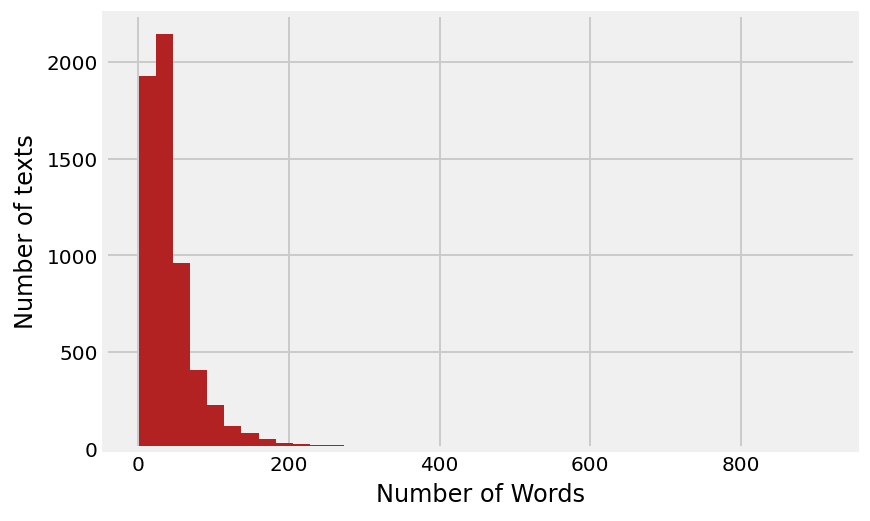

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[2, 25102, 1050, 30357, 4425, 1371, 30470, 3], [2, 29236, 533, 30470, 3, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0]]}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

## Freeze Layers

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

## Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,10)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 30

time: 16.1 ms (started: 2022-11-14 21:45:40 +00:00)


##Define Train & Evaluate Function

In [ ]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

## Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/thesis/c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.997
Validation Loss: 1.855

 Epoch 2 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.841
Validation Loss: 1.818

 Epoch 3 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.815
Validation Loss: 1.802

 Epoch 4 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.803
Validation Loss: 1.790

 Epoch 5 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.792
Validation Loss: 1.781

 Epoch 6 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  of    190.

Evaluating...

Training Loss: 1.785
Validation Loss: 1.772

 Epoch 7 / 30
  Batch    50  of    190.
  Batch   100  of    190.
  Batch   150  

## Model performance

In [ ]:
# load weights of best model
#path = '/content/drive/MyDrive/thesis/c1_fakenews_weights.pt'
#model.load_state_dict(torch.load(path))

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.44      0.35      0.39       172
           2       0.00      0.00      0.00        42
           3       0.35      0.50      0.42       334
           4       0.68      0.28      0.40        75
           5       0.11      0.01      0.01       170
           6       0.36      0.60      0.45       393
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        35

    accuracy                           0.37      1302
   macro avg       0.22      0.19      0.19      1302
weighted avg       0.31      0.37      0.32      1302



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fake News Predictions

In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# testing on unseen data
unseen_news_text = ["Video Presiden Joko Widodo Jenguk Lesti Kejora Di Rumah Sakit  Tanpa Kehadiran Rizky Billar",     # Fake
                    "mengapa satgasus dibubarkan setelah kasus Sambo Mencuat?",               # Fake
                    "Puluhan Orang Cidera Parah Gas Air Mata Hujani Masa Aksi 411 yang Sedang Sholat",           # Fake
                    "Muak Dengan Kelicikan Barat, Puluhan Kepala Negara Minta Jokowi Bentuk Sekaligus Pimpin PBB Baru"                          # Fake
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 200
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([6, 5, 3, 3])

#Claim Verification

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# specify GPU
device = torch.device("cuda")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/claim_dataset.csv', sep='\t', nrows=500)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/claim_dataset.csv', sep='\t')

In [ ]:
df.head()

,Unnamed: 0,title,content,fact,source_issue,tanggal,classification,label
0,2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6
1,5,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6
2,6,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6
3,9,[SALAH] “Beredar Video Diduga Mempertontonkan ...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6
4,10,"[SALAH] SUARA GANJAR GETARKAN JAKARTA, 30.000 ...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6


In [ ]:
# Remove [SALAH] from the fact column
df["title"] = df["title"].str.replace("\[SALAH\]", "", regex=True)

# Create a new column "claim" and store the classification result
df["claim"] = df["classification"].apply(lambda x: "support" if x == "TRUE" else "reject")

# Create a new column "claim_label" and set the value based on "claim" column
df["claim_label"] = df["claim"].apply(lambda x: 1 if x == "support" else 2 if x == "reject" else 0)


# Display the modified dataframe
df.head()

,Unnamed: 0,title,content,fact,source_issue,tanggal,classification,label,claim,claim_label
0,2,Menkes Budi Gunadi Sadikin: “Diabetes Mudah D...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6,reject,2
1,5,Kebijakan Pemerintah Tiongkok yang Mewajibkan...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6,reject,2
2,6,Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6,reject,2
3,9,“Beredar Video Diduga Mempertontonkan Pasanga...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6,reject,2
4,10,"SUARA GANJAR GETARKAN JAKARTA, 30.000 WARGA D...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6,reject,2


In [ ]:
unique_values = df["claim"].nunique()

# Print the number of unique values
print("The number of unique values in the column is:", unique_values)

The number of unique values in the column is: 2


In [ ]:
df.claim.value_counts()

reject     8507
support     420
Name: claim, dtype: int64

In [ ]:
df.head()

,Unnamed: 0,title,content,fact,source_issue,tanggal,classification,label,claim,claim_label
0,2,Menkes Budi Gunadi Sadikin: “Diabetes Mudah D...,akun facebook nama k menyebarluaskan taut a ga...,laku telusur google reverse citra cari gambar ...,facebook.com,2022-11-10,Misleading Content,6,reject,2
1,5,Kebijakan Pemerintah Tiongkok yang Mewajibkan...,akun twitter nama uytimes unggah buah video ke...,dasar hasil telusur narasi hoaks edar anak ana...,twitter.com,2022-11-10,Misleading Content,6,reject,2
2,6,Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,edar video tiktok unggah briar cares tampil ma...,Tiktok,2022-11-09,Misleading Content,6,reject,2
3,9,“Beredar Video Diduga Mempertontonkan Pasanga...,edar video duga mempe ontonkan pasang lgbt mes...,edar video duga mempe ontonkan pasang lgbt mes...,Tiktok,2022-11-09,Misleading Content,6,reject,2
4,10,"SUARA GANJAR GETARKAN JAKARTA, 30.000 WARGA D...",suara ganjar getar jaka a 30 000 warga desa ri...,channel youtube nama ceria televisi unggah bua...,Youtube,2022-11-09,Misleading Content,6,reject,2


In [ ]:
# Filter the data to only include support and reject claims
data = df[df['claim'].isin(['support', 'reject'])]

# Randomly sample 200 items from each class
support_data = data[df['claim'] == 'support'].sample(n=200, random_state=42)
reject_data = data[df['claim'] == 'reject'].sample(n=200, random_state=42)

# Combine the two samples into a single dataframe
data = pd.concat([support_data, reject_data])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 8046 to 8871
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      400 non-null    int64 
 1   title           400 non-null    object
 2   content         312 non-null    object
 3   fact            396 non-null    object
 4   source_issue    288 non-null    object
 5   tanggal         400 non-null    object
 6   classification  400 non-null    object
 7   label           400 non-null    int64 
 8   claim           400 non-null    object
 9   claim_label     400 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 34.4+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8927 entries, 0 to 8926
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      8927 non-null   int64 
 1   title           8926 non-null   object
 2   content         8681 non-null   object
 3   fact            8860 non-null   object
 4   source_issue    8366 non-null   object
 5   tanggal         8927 non-null   object
 6   classification  8927 non-null   object
 7   label           8927 non-null   int64 
 8   claim           8927 non-null   object
 9   claim_label     8927 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 697.5+ KB


In [ ]:
# Define the labels to use for classification
labels = ["support", "reject", "neutral"]

# Define the dictionary to convert labels to integers
label_map = {label: i for i, label in enumerate(labels)}

# Select 400 rows from the data that have labels in the list of possible labels
selected_data = df[df["claim"].isin(labels)].sample(n=400, random_state=42)

# Initialize the IndoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(labels))

# Set the model to evaluate mode
model.eval()

# Define the lists for the true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through each row in the selected data
for index, row in selected_data.iterrows():
    # Get the claim and evidence from the title and fact columns, respectively
    claim = str(row["title"])
    evidence = str(row["fact"])
    label = row["claim"]
    
    # Convert the label to an integer
    true_label = label_map[label]
    
    # Tokenize the claim and evidence
    inputs = tokenizer.encode_plus(claim, evidence, add_special_tokens=True, return_tensors="pt", max_length=512, truncation=True)
    
    # Pass the inputs to the model and get the logits
    logits = model(**inputs).logits
    
    # Get the predicted label based on the highest logit value
    predicted_label = labels[torch.argmax(logits, axis=1)]
    
    # Add the true and predicted labels to the respective lists
    true_labels.append(true_label)
    predicted_labels.append(label_map[predicted_label])

# Check if there are any labels in the true_labels list
if len(true_labels) > 0:
    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=labels, zero_division=1))
else:
    print("No labels found in data")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: ignored

In [ ]:
# Define the labels to use for classification
labels = ["support", "reject", "neutral"]

# Define the dictionary to convert labels to integers
label_map = {label: i for i, label in enumerate(labels)}

# Select 400 rows from the data that have labels in the list of possible labels
selected_data = df[df["claim"].isin(labels)].sample(n=8927, random_state=42)

# Initialize the IndoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(labels))

# Set the model to evaluate mode
model.eval()

# Define the lists for the true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through each row in the selected data
for index, row in selected_data.iterrows():
    # Get the claim and evidence from the title and fact columns, respectively
    claim = str(row["title"])
    evidence = str(row["fact"])
    label = row["claim"]
    
    # Convert the label to an integer
    true_label = label_map[label]
    
    # Tokenize the claim and evidence
    inputs = tokenizer.encode_plus(claim, evidence, add_special_tokens=True, return_tensors="pt", max_length=512, truncation=True)
    
    # Pass the inputs to the model and get the logits
    logits = model(**inputs).logits
    
    # Get the predicted label based on the highest logit value
    predicted_label = labels[torch.argmax(logits, axis=1)]
    
    # Add the true and predicted labels to the respective lists
    true_labels.append(true_label)
    predicted_labels.append(label_map[predicted_label])

# Check if there are any labels in the true_labels list
if len(true_labels) > 0:
    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=labels, zero_division=1))
else:
    print("No labels found in data")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

     support       0.09      0.20      0.12       420
      reject       0.96      0.86      0.91      8507
     neutral       0.00      1.00      0.00         0

    accuracy                           0.83      8927
   macro avg       0.35      0.69      0.34      8927
weighted avg       0.92      0.83      0.87      8927



In [ ]:
import pandas as pd
import torch
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# Load the CSV file
#df = pd.read_csv("data.csv")

# Define the labels to use for classification
labels = ["support", "reject", "neutral"]

# Define the dictionary to convert labels to integers
label_map = {label: i for i, label in enumerate(labels)}

# Select the rows with the selected labels
selected_data = df[df["claim"].isin(labels)]

# Split the data into training and testing sets using stratified sampling
train_data, test_data = train_test_split(selected_data, test_size=0.25, random_state=42, stratify=selected_data["claim"])

# Initialize the IndoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=len(labels))

# Set the model to evaluate mode
model.eval()

# Define the lists for the true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through each row in the test data
for index, row in test_data.iterrows():
    # Get the claim and evidence from the title and fact columns, respectively
    claim = str(row["title"])
    evidence = str(row["fact"])
    label = row["claim"]
    
    # Convert the label to an integer
    true_label = label_map[label]
    
    # Tokenize the claim and evidence
    inputs = tokenizer.encode_plus(claim, evidence, add_special_tokens=True, return_tensors="pt", max_length=512, truncation=True)
    
    # Pass the inputs to the model and get the logits
    logits = model(**inputs).logits
    
    # Get the predicted label based on the highest logit value
    predicted_label = labels[torch.argmax(logits, axis=1)]
    
    # Add the true and predicted labels to the respective lists
    true_labels.append(true_label)
    predicted_labels.append(label_map[predicted_label])

# Check if there are any labels in the true_labels list
if len(true_labels) > 0:
    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=labels, zero_division=1))
else:
    print("No labels found in test data")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

     support       0.03      0.03      0.03       105
      reject       0.99      0.04      0.07      2127
     neutral       0.00      1.00      0.00         0

    accuracy                           0.04      2232
   macro avg       0.34      0.35      0.03      2232
weighted avg       0.94      0.04      0.07      2232

